In [1]:
import numpy as np
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import itertools

[nltk_data] Downloading package stopwords to /Users/tae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# data preprocess
stemmer = PorterStemmer()
punc = set(string.punctuation)
full_data = []

def loadData(file):
    data, label = [], []
    for line in open(file):
        tmp_data, tmp_label = line.rstrip().split('\t')
        tmp_data = tmp_data.lower()
        tmp_data = ''.join(word for word in tmp_data if word not in punc)
        full_data.append(tmp_data)
        tmp_data = word_tokenize(tmp_data)
        tmp_data = [stemmer.stem(word) for word in tmp_data if word not in stopwords.words("english")]
        data.append(tmp_data)
        label.append(int(tmp_label))
    return np.array(data), np.array(label)

In [3]:
amazon_data, amazon_label = loadData("data/sentiment labelled sentences/amazon_cells_labelled.txt")
yelp_data, yelp_label = loadData("data/sentiment labelled sentences/yelp_labelled.txt")
imdb_data, imdb_label = loadData("data/sentiment labelled sentences/imdb_labelled.txt")

In [4]:
# ratio between 2 labels
ratio_amazon = np.count_nonzero(amazon_label == 1) / np.count_nonzero(amazon_label == 0)
ratio_yelp = np.count_nonzero(yelp_label == 1) / np.count_nonzero(yelp_label == 0)
ratio_imdb = np.count_nonzero(imdb_label == 1) / np.count_nonzero(imdb_label == 0)
print("Positive / Negative ratio within amazon dataset is %f" %ratio_amazon)
print("Positive / Negative ratio within yelp dataset is %f" %ratio_yelp)
print("Positive / Negative ratio within imdb dataset is %f" %ratio_imdb)

Positive / Negative ratio within amazon dataset is 1.000000
Positive / Negative ratio within yelp dataset is 1.000000
Positive / Negative ratio within imdb dataset is 1.000000


In [5]:
# train test split
data = np.concatenate((amazon_data, yelp_data, imdb_data))
labels = np.concatenate((amazon_label, yelp_label, imdb_label))

def train_test_split(data, labels):
    train_data, train_label = [], []
    test_data, test_label = [], []
    for f in range(0, 3):
        start = f*1000
        one = 0
        zero = 0
        for i in range(start, start + 1000):
            if labels[i] == 1:
                one += 1
                if one <= 400:
                    train_data.append(data[i])
                    train_label.append(1)
                else:
                    test_data.append(data[i])
                    test_label.append(1)
            else:
                zero += 1
                if zero <= 400:
                    train_data.append(data[i])
                    train_label.append(0)
                else:
                    test_data.append(data[i])
                    test_label.append(0)
    return np.array(train_data), np.array(train_label), np.array(test_data), np.array(test_label)

train_data, train_label, test_data, test_label = train_test_split(data, labels)

In [6]:
# Bag of words

# get word dict
def get_word_dict(data):
    word_dict = {}
    i = 0
    for sentence in data:
        for word in sentence:
            if word not in word_dict:
                word_dict[word] = i
                i += 1
    return word_dict
   
# get bag of words feature vectors
def bag_of_word(data, dict_):
    features = []
    for sentence in data:
        tmp = np.zeros(len(dict_))
        for word in sentence:
            if word in dict_:
                tmp[dict_[word]] += 1
        features.append(tmp)
    return np.array(features)
    
word_dict = get_word_dict(train_data)
train_data_ = bag_of_word(train_data, word_dict)
test_data_ = bag_of_word(test_data, word_dict)
print(train_data_[:2])

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
# Post Processing
def post_processing(train, test):
    transformer = TfidfTransformer(smooth_idf=False)
    train_ = transformer.fit_transform(train).toarray()
    test_ = transformer.fit_transform(test).toarray()
    return train_, test_
train_, test_ = post_processing(train_data_, test_data_)

/Users/tae/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1278: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


Logistic Regression accuracy on testset is 0.816667


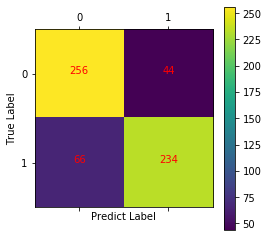

The most 10 important words are: [['great'], ['love'], ['bad'], ['excel'], ['good'], ['nice'], ['poor'], ['delici'], ['best'], ['worst']]


In [8]:
# Logistic Regression
def logistic(train_data, train_label, test_data, test_label, dict_, n=10):
    # regression
    clf = LogisticRegression(solver = 'liblinear')
    clf.fit(train_data, train_label)
    acc = clf.score(test_data, test_label)
    print("Logistic Regression accuracy on testset is %f" %acc)
    # confusion matrix
    y_pred = clf.predict(test_data)
    matrix = confusion_matrix(test_label, y_pred)
    matrix_plot(matrix)
    # most important words
    index = np.argsort(-np.absolute(clf.coef_))[0][:n]
    important_words = []
    keys = list(dict_.keys())
    for i in index:
        important_words.append([keys[i]])
    print("The most %d important words are:" %n, important_words)

    
def matrix_plot(matrix):
    plt.matshow(matrix)
    plt.colorbar()
    plt.xlabel('Predict Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(matrix.shape[1]))
    plt.yticks(np.arange(matrix.shape[1]))
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment="center",
                 color="red")
    plt.show()
    
logistic(train_, train_label, test_, test_label, word_dict, n=10)

Naive Bayes accuracy on testset is 0.685000


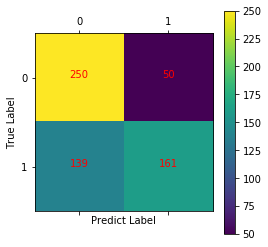

The most 10 important words are: [['disappoint'], ['bad'], ['wast'], ['dont'], ['back'], ['terribl'], ['servic'], ['poor'], ['movi'], ['money']]


In [9]:
# Naive Bayes
def naive_bayes(train_data, train_label, test_data, test_label, dict_, n=10):
    clf = GaussianNB()
    clf.fit(train_data, train_label)
    acc = clf.score(test_data, test_label)
    print("Naive Bayes accuracy on testset is %f" %acc)
    # confusion matrix
    y_pred = clf.predict(test_data)
    matrix = confusion_matrix(test_label, y_pred)
    matrix_plot(matrix)
    # most important words
    index = np.argsort(-np.absolute(clf.sigma_))[0][:n]
    important_words = []
    keys = list(dict_.keys())
    for i in index:
        important_words.append([keys[i]])
    print("The most %d important words are:" %n, important_words)

naive_bayes(train_, train_label, test_, test_label, word_dict, 10)

In [10]:
# N-gram
def get_ngram_data(data, n=2):
    new_data = []
    for sentence in data:
        sentence = [word for word in sentence.split(" ") if word != ""]
        tmp = list(ngrams(sentence, n))
        new_data.append(tmp)
    return new_data

# get word dict
def get_word_dict_ngram(data):
    word_dict = {}
    i = 0
    for sentence in data:
        for word in sentence:
            if word not in word_dict:
                word_dict[word] = i
                i += 1
    return word_dict
   
# get bag of words feature vectors
def bag_of_word_ngram(data, dict_):
    features = []
    for sentence in data:
        tmp = np.zeros(len(dict_))
        for word in sentence:
            if word in dict_:
                tmp[dict_[word]] += 1
        features.append(tmp)
    return np.array(features)

full_ngram = get_ngram_data(full_data)
train_ngram, train_label_ng, test_ngram, test_label_ng = train_test_split(full_ngram, labels)
word_dict_ngram = get_word_dict_ngram(train_ngram)
train_ngram_ = bag_of_word_ngram(train_ngram, word_dict_ngram)
test_ngram_ = bag_of_word_ngram(test_ngram, word_dict_ngram)
train_ng, test_ng = post_processing(train_ngram_, test_ngram_)

/Users/tae/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1278: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


-------Logistice Regression on N-gram Model-------
Logistic Regression accuracy on testset is 0.728333


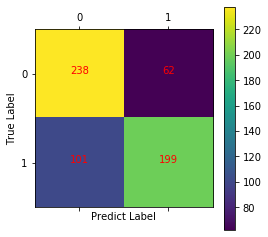

The most 10 important words are: [[('a', 'great')], [('the', 'best')], [('works', 'great')], [('very', 'good')], [('the', 'worst')], [('would', 'not')], [('love', 'this')], [('do', 'not')], [('i', 'love')], [('very', 'disappointed')]]
-------Naive Bayes on N-gram Model-------
Naive Bayes accuracy on testset is 0.705000


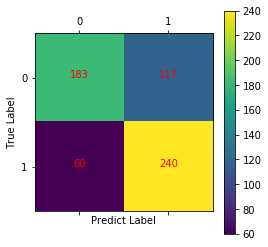

The most 10 important words are: [[('very', 'disappointing')], [('very', 'disappointed')], [('it', 'was')], [('was', 'terrible')], [('what', 'a')], [('not', 'good')], [('waste', 'your')], [('not', 'recommended')], [('would', 'not')], [('dont', 'waste')]]


In [11]:
print("-------Logistice Regression on N-gram Model-------")
logistic(train_ng, train_label, test_ng, test_label, word_dict_ngram, n=10)
print("-------Naive Bayes on N-gram Model-------")
naive_bayes(train_ng, train_label, test_ng, test_label, word_dict_ngram, n=10)

In [12]:
# PCA
def pca(data):
    data -= np.mean(data, axis=0)
    cov = np.cov(data.T)
    eigen_value, eigen_vec = np.linalg.eigh(cov)
    index = np.argsort(eigen_value)[::-1]
    eigen_value = eigen_value[index]
    eigen_vec = eigen_vec[:, index]
#     return np.matmul(data, eigen_vec)
    return data, eigen_vec, eigen_value

------- PCA N = 10 -------
- Logoistic Regression -
Logistic Regression accuracy on testset is 0.621667


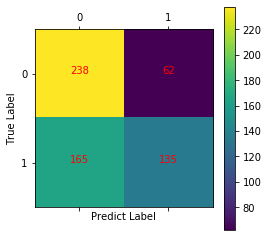

The most 10 important words are: [['us'], ['way'], ['valu'], ['case'], ['excel'], ['good'], ['plug'], ['unless'], ['go'], ['convert']]
- Naive Bayes -
Naive Bayes accuracy on testset is 0.581667


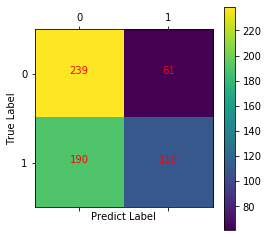

The most 10 important words are: [['excel'], ['valu'], ['unless'], ['good'], ['convert'], ['way'], ['go'], ['case'], ['plug'], ['us']]
------- PCA N = 50 -------
- Logoistic Regression -
Logistic Regression accuracy on testset is 0.705000


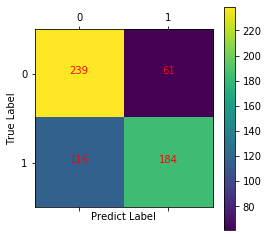

The most 10 important words are: [['us'], ['valu'], ['imagin'], ['mic'], ['way'], ['dozen'], ['jawbon'], ['last'], ['impress'], ['sound']]
- Naive Bayes -
Naive Bayes accuracy on testset is 0.633333


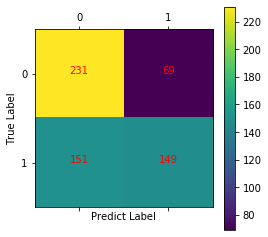

The most 10 important words are: [['jawbon'], ['excel'], ['valu'], ['unless'], ['good'], ['convert'], ['way'], ['great'], ['go'], ['case']]
------- PCA N = 100 -------
- Logoistic Regression -
Logistic Regression accuracy on testset is 0.718333


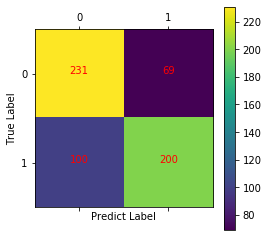

The most 10 important words are: [['us'], ['valu'], ['imagin'], ['way'], ['dozen'], ['mic'], ['went'], ['jawbon'], ['impress'], ['commerci']]
- Naive Bayes -
Naive Bayes accuracy on testset is 0.645000


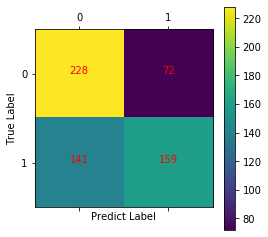

The most 10 important words are: [['jawbon'], ['excel'], ['valu'], ['unless'], ['good'], ['convert'], ['way'], ['great'], ['go'], ['case']]


In [13]:
# PCA for bag-of-words model 
N = [10, 50, 100]
bag_, vec_, val_ = pca(train_data_)
new_test_ = test_data_ - np.mean(test_data_, axis=0)
for n in N:
    print("------- PCA N = %d -------" %n)
    new_train = np.matmul(bag_, vec_[:,:n])
    new_test = np.matmul(new_test_, vec_[:,:n])
    print("- Logoistic Regression -")
    logistic(new_train, train_label, new_test, test_label, word_dict, n=10)
    print("- Naive Bayes -")
    naive_bayes(new_train, train_label, new_test, test_label, word_dict, 10)

------- PCA N = 10 -------
- Logoistic Regression -
Logistic Regression accuracy on testset is 0.525000


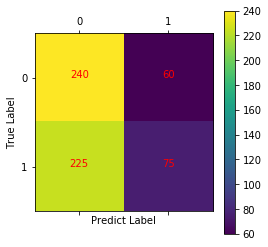

The most 10 important words are: [[('there', 'is')], [('so', 'there')], [('me', 'to')], [('no', 'way')], [('for', 'me')], [('way', 'for')], [('it', 'in')], [('is', 'no')], [('to', 'plug')], [('plug', 'it')]]
- Naive Bayes -
Naive Bayes accuracy on testset is 0.506667


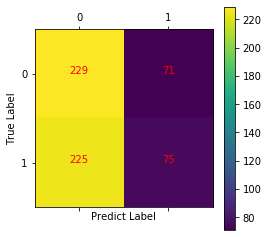

The most 10 important words are: [[('so', 'there')], [('is', 'no')], [('way', 'for')], [('to', 'plug')], [('there', 'is')], [('no', 'way')], [('it', 'in')], [('for', 'me')], [('me', 'to')], [('plug', 'it')]]
------- PCA N = 50 -------
- Logoistic Regression -
Logistic Regression accuracy on testset is 0.571667


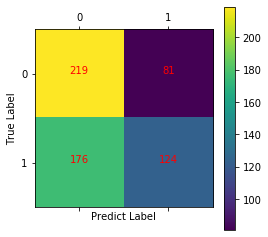

The most 10 important words are: [[('the', 'mic')], [('great', 'for')], [('a', 'converter')], [('jiggle', 'the')], [('than', '45')], [('there', 'is')], [('conversations', 'lasting')], [('charger', 'for')], [('go', 'by')], [('minutesmajor', 'problems')]]
- Naive Bayes -
Naive Bayes accuracy on testset is 0.511667


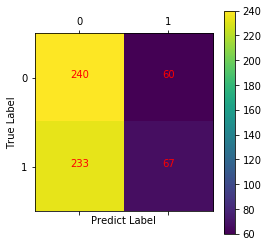

The most 10 important words are: [[('so', 'there')], [('is', 'no')], [('way', 'for')], [('to', 'plug')], [('there', 'is')], [('no', 'way')], [('it', 'in')], [('for', 'me')], [('me', 'to')], [('plug', 'it')]]
------- PCA N = 100 -------
- Logoistic Regression -
Logistic Regression accuracy on testset is 0.621667


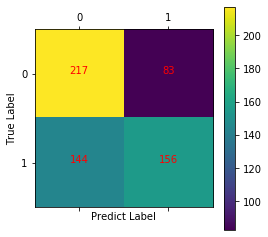

The most 10 important words are: [[('the', 'mic')], [('sound', 'quality')], [('great', 'for')], [('a', 'converter')], [('jiggle', 'the')], [('than', '45')], [('several', 'dozen')], [('you', 'are')], [('say', 'i')], [('what', 'a')]]
- Naive Bayes -
Naive Bayes accuracy on testset is 0.528333


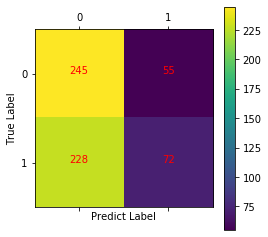

The most 10 important words are: [[('so', 'there')], [('is', 'no')], [('way', 'for')], [('to', 'plug')], [('there', 'is')], [('no', 'way')], [('it', 'in')], [('for', 'me')], [('me', 'to')], [('plug', 'it')]]


In [15]:
bag_ng, vec_ng, val_ng = pca(train_ngram_)
new_test_ng = test_ngram_ - np.mean(test_ngram_, axis=0)
for n in N:
    print("------- PCA N = %d -------" %n)
    new_train = np.matmul(bag_ng, vec_ng[:,:n])
    new_test = np.matmul(new_test_ng, vec_ng[:,:n])
    print("- Logoistic Regression -")
    logistic(new_train, train_label, new_test, test_label, word_dict_ngram, n=10)
    print("- Naive Bayes -")
    naive_bayes(new_train, train_label, new_test, test_label, word_dict_ngram, 10)